In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from prediction_vis import visualize_time_series_grid_difference
from models import unet
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import BCELoss, MSELoss


In [12]:
files = [
    r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt00.npy",
    r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt01.npy",
    r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt02.npy",
    r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt03.npy",
     r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt04.npy",
     r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt05.npy",
     r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt06.npy",
     r"dynamic_scenes2d\dynamic_scenes2d_motionv01_64_6_1000_40_pt07.npy",
   
]

# t + 10

In [3]:

class Dataset_t10(Dataset):
    def __init__(self, npy_files, input_len=10, pred_offset=10):
        """
        npy_files: list of paths
        input_len: number of input frames (10)
        pred_offset: how far in future to predict (10)
        """
        self.input_len = input_len
        self.pred_offset = pred_offset

        self.data = []
        for f in npy_files:
            arr = np.load(f)  # (N, T, C, H, W)
            self.data.append(arr)
        
        self.data = np.concatenate(self.data, axis=0)
        self.data = self.data[:,:,None,:,:]
        self.N, self.T, self.C, self.H, self.W = self.data.shape

        # valid t positions
        self.valid_t = list(range(input_len-1, self.T - pred_offset))

        self.samples_per_seq = len(self.valid_t)
        self.total_samples = self.N * self.samples_per_seq

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        seq_idx = idx // self.samples_per_seq
        t_idx = idx % self.samples_per_seq
        t = self.valid_t[t_idx]

        seq = self.data[seq_idx]

        x = seq[t - self.input_len + 1 : t + 1]      # (10,1,64,64)
        y = seq[t + self.pred_offset]                # (1,64,64)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        # flatten time into channels for U-Net
        x = x.reshape(-1, self.H, self.W)

        return x, y


In [4]:
dataset = Dataset_t10(files, input_len=10, pred_offset=10)

n_total = len(dataset)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

In [5]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm


EPOCHS = 50
BATCH_SIZE = 1024
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "unet_model_3.pt"
print(DEVICE)


model = unet.UNet(in_channels=10, out_channels=1).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.L1Loss()


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


best_val = float("inf")

for epoch in range(EPOCHS):

    if os.path.exists("loss_t10.npy"):
        loss_history = list(np.load("loss_t10.npy"))
    else:
        loss_history = []
    model.train()
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred_delta = model(x)
        pred = x[:, -1:] + pred_delta
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            pred_delta = model(x)
            pred = x[:, -1:] + pred_delta
            loss = criterion(pred, y)

            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)
    loss_history.append((epoch ,train_loss, val_loss))

    print(f"Epoch {epoch+1}: Train {train_loss:.5f} | Val {val_loss:.5f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print("✔ Saved best model")

    np.save("loss_t10.npy", np.array(loss_history))


cuda


Epoch 1/50: 100%|██████████| 148/148 [13:31<00:00,  5.48s/it]


Epoch 1: Train 0.10674 | Val 0.07623
✔ Saved best model


Epoch 2/50: 100%|██████████| 148/148 [13:29<00:00,  5.47s/it]


Epoch 2: Train 0.07024 | Val 0.06683
✔ Saved best model


Epoch 3/50: 100%|██████████| 148/148 [13:27<00:00,  5.45s/it]


Epoch 3: Train 0.06302 | Val 0.05866
✔ Saved best model


Epoch 4/50: 100%|██████████| 148/148 [13:25<00:00,  5.44s/it]


Epoch 4: Train 0.05472 | Val 0.05205
✔ Saved best model


Epoch 5/50: 100%|██████████| 148/148 [13:17<00:00,  5.39s/it]


Epoch 5: Train 0.04919 | Val 0.04827
✔ Saved best model


Epoch 6/50: 100%|██████████| 148/148 [13:28<00:00,  5.46s/it]


Epoch 6: Train 0.04523 | Val 0.04492
✔ Saved best model


Epoch 7/50: 100%|██████████| 148/148 [13:27<00:00,  5.46s/it]


Epoch 7: Train 0.04211 | Val 0.04332
✔ Saved best model


Epoch 8/50: 100%|██████████| 148/148 [13:28<00:00,  5.46s/it]


Epoch 8: Train 0.03970 | Val 0.04105
✔ Saved best model


Epoch 9/50: 100%|██████████| 148/148 [13:27<00:00,  5.45s/it]


Epoch 9: Train 0.03785 | Val 0.03914
✔ Saved best model


Epoch 10/50: 100%|██████████| 148/148 [13:29<00:00,  5.47s/it]


Epoch 10: Train 0.03625 | Val 0.03833
✔ Saved best model


Epoch 11/50: 100%|██████████| 148/148 [13:28<00:00,  5.46s/it]


Epoch 11: Train 0.03512 | Val 0.03716
✔ Saved best model


Epoch 12/50: 100%|██████████| 148/148 [13:26<00:00,  5.45s/it]


Epoch 12: Train 0.03383 | Val 0.03575
✔ Saved best model


Epoch 13/50: 100%|██████████| 148/148 [13:25<00:00,  5.44s/it]


Epoch 13: Train 0.03274 | Val 0.03651


Epoch 14/50: 100%|██████████| 148/148 [13:21<00:00,  5.41s/it]


Epoch 14: Train 0.03178 | Val 0.03381
✔ Saved best model


Epoch 15/50: 100%|██████████| 148/148 [13:18<00:00,  5.39s/it]


Epoch 15: Train 0.03081 | Val 0.03409


Epoch 16/50: 100%|██████████| 148/148 [13:10<00:00,  5.34s/it]


Epoch 16: Train 0.02996 | Val 0.03296
✔ Saved best model


Epoch 17/50: 100%|██████████| 148/148 [13:06<00:00,  5.32s/it]


Epoch 17: Train 0.02931 | Val 0.03248
✔ Saved best model


Epoch 18/50: 100%|██████████| 148/148 [13:11<00:00,  5.35s/it]


Epoch 18: Train 0.02852 | Val 0.03264


Epoch 19/50: 100%|██████████| 148/148 [13:04<00:00,  5.30s/it]


Epoch 19: Train 0.02816 | Val 0.03176
✔ Saved best model


Epoch 20/50: 100%|██████████| 148/148 [13:10<00:00,  5.34s/it]


Epoch 20: Train 0.02739 | Val 0.03050
✔ Saved best model


Epoch 21/50: 100%|██████████| 148/148 [13:10<00:00,  5.34s/it]


Epoch 21: Train 0.02687 | Val 0.02996
✔ Saved best model


Epoch 22/50: 100%|██████████| 148/148 [13:05<00:00,  5.30s/it]


Epoch 22: Train 0.02650 | Val 0.03033


Epoch 23/50: 100%|██████████| 148/148 [13:11<00:00,  5.35s/it]


Epoch 23: Train 0.02597 | Val 0.02894
✔ Saved best model


Epoch 24/50: 100%|██████████| 148/148 [13:11<00:00,  5.35s/it]


Epoch 24: Train 0.02541 | Val 0.02883
✔ Saved best model


Epoch 25/50: 100%|██████████| 148/148 [13:04<00:00,  5.30s/it]


Epoch 25: Train 0.02525 | Val 0.02850
✔ Saved best model


Epoch 26/50: 100%|██████████| 148/148 [13:12<00:00,  5.35s/it]


Epoch 26: Train 0.02486 | Val 0.02814
✔ Saved best model


Epoch 27/50: 100%|██████████| 148/148 [13:14<00:00,  5.37s/it]


Epoch 27: Train 0.02421 | Val 0.02792
✔ Saved best model


Epoch 28/50: 100%|██████████| 148/148 [13:10<00:00,  5.34s/it]


Epoch 28: Train 0.02399 | Val 0.02742
✔ Saved best model


Epoch 29/50: 100%|██████████| 148/148 [13:12<00:00,  5.35s/it]


Epoch 29: Train 0.02334 | Val 0.02685
✔ Saved best model


Epoch 30/50: 100%|██████████| 148/148 [13:17<00:00,  5.39s/it]


Epoch 30: Train 0.02324 | Val 0.02762


Epoch 31/50: 100%|██████████| 148/148 [13:04<00:00,  5.30s/it]


Epoch 31: Train 0.02301 | Val 0.02679
✔ Saved best model


Epoch 32/50: 100%|██████████| 148/148 [13:08<00:00,  5.33s/it]


Epoch 32: Train 0.02285 | Val 0.02624
✔ Saved best model


Epoch 33/50: 100%|██████████| 148/148 [13:10<00:00,  5.34s/it]


Epoch 33: Train 0.02224 | Val 0.02554
✔ Saved best model


Epoch 34/50: 100%|██████████| 148/148 [12:59<00:00,  5.27s/it]


Epoch 34: Train 0.02204 | Val 0.02576


Epoch 35/50: 100%|██████████| 148/148 [13:09<00:00,  5.33s/it]


Epoch 35: Train 0.02162 | Val 0.02545
✔ Saved best model


Epoch 36/50: 100%|██████████| 148/148 [13:07<00:00,  5.32s/it]


Epoch 36: Train 0.02153 | Val 0.02506
✔ Saved best model


Epoch 37/50: 100%|██████████| 148/148 [13:09<00:00,  5.33s/it]


Epoch 37: Train 0.02110 | Val 0.02532


Epoch 38/50: 100%|██████████| 148/148 [13:21<00:00,  5.42s/it]


Epoch 38: Train 0.02105 | Val 0.02506


Epoch 39/50: 100%|██████████| 148/148 [13:16<00:00,  5.38s/it]


Epoch 39: Train 0.02080 | Val 0.02501
✔ Saved best model


Epoch 40/50: 100%|██████████| 148/148 [13:18<00:00,  5.40s/it]


Epoch 40: Train 0.02042 | Val 0.02450
✔ Saved best model


Epoch 41/50: 100%|██████████| 148/148 [13:17<00:00,  5.39s/it]


Epoch 41: Train 0.02038 | Val 0.02528


Epoch 42/50: 100%|██████████| 148/148 [13:18<00:00,  5.39s/it]


Epoch 42: Train 0.02045 | Val 0.02523


Epoch 43/50: 100%|██████████| 148/148 [13:14<00:00,  5.37s/it]


Epoch 43: Train 0.02018 | Val 0.02414
✔ Saved best model


Epoch 44/50: 100%|██████████| 148/148 [13:16<00:00,  5.38s/it]


Epoch 44: Train 0.01992 | Val 0.02446


Epoch 45/50: 100%|██████████| 148/148 [13:22<00:00,  5.42s/it]


Epoch 45: Train 0.01976 | Val 0.02366
✔ Saved best model


Epoch 46/50: 100%|██████████| 148/148 [13:19<00:00,  5.40s/it]


Epoch 46: Train 0.01961 | Val 0.02384


Epoch 47/50: 100%|██████████| 148/148 [13:21<00:00,  5.41s/it]


Epoch 47: Train 0.01929 | Val 0.02344
✔ Saved best model


Epoch 48/50: 100%|██████████| 148/148 [13:12<00:00,  5.35s/it]


Epoch 48: Train 0.01936 | Val 0.02399


Epoch 49/50: 100%|██████████| 148/148 [13:15<00:00,  5.38s/it]


Epoch 49: Train 0.01897 | Val 0.02358


Epoch 50/50: 100%|██████████| 148/148 [13:11<00:00,  5.35s/it]


Epoch 50: Train 0.01878 | Val 0.02329
✔ Saved best model


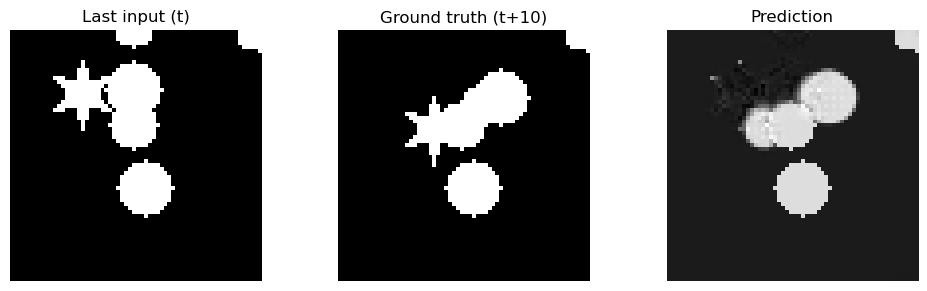

In [6]:
import torch
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model = unet.UNet(in_channels=10, out_channels=1).to(DEVICE)
model.load_state_dict(torch.load("unet_model_2.pt", map_location=DEVICE))
model.eval()


x, y = next(iter(val_loader))   # or train_loader
x = x.to(DEVICE)
y = y.to(DEVICE)


with torch.no_grad():
    pred_delta = model(x)
    pred = x[:, -1:] + pred_delta

x0 = x[3].cpu()
y0 = y[3].cpu()
p0 = pred[3].cpu()

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.title("Last input (t)")
plt.imshow(x0[-1], cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground truth (t+10)")
plt.imshow(y0[0], cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(p0[0], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


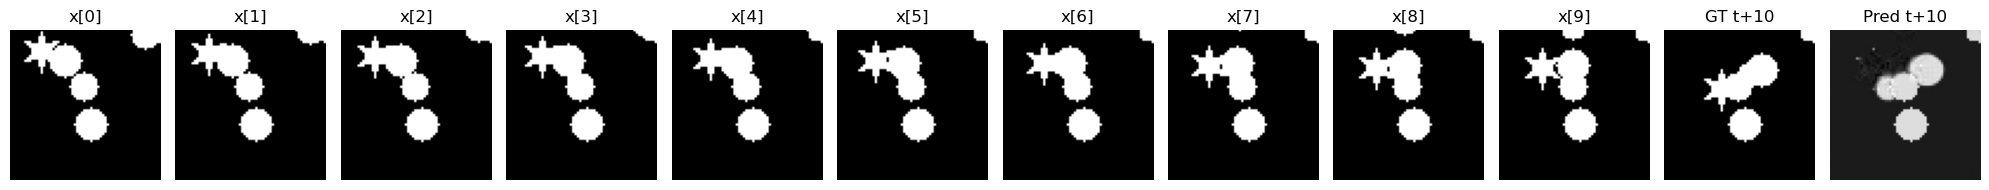

In [7]:
import matplotlib.pyplot as plt

model.eval()
x, y = next(iter(val_loader))
x = x.to(DEVICE)
y = y.to(DEVICE)

with torch.no_grad():
    pred = x[:, -1:] + model(x)

x0 = x[3].cpu()
y0 = y[3].cpu()
p0 = pred[3].cpu()

plt.figure(figsize=(20,3))

for i in range(10):
    plt.subplot(1, 12, i+1)
    plt.title(f"x[{i}]")
    plt.imshow(x0[i], cmap="gray")
    plt.axis("off")

plt.subplot(1,12,11)
plt.title("GT t+10")
plt.imshow(y0[0], cmap="gray")
plt.axis("off")

plt.subplot(1,12,12)
plt.title("Pred t+10")
plt.imshow(p0[0], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
model.eval()
x, y = next(iter(val_loader))
x = x.to(DEVICE)
y = y.to(DEVICE)

with torch.no_grad():
    pred = x[:, -1:] + model(x)

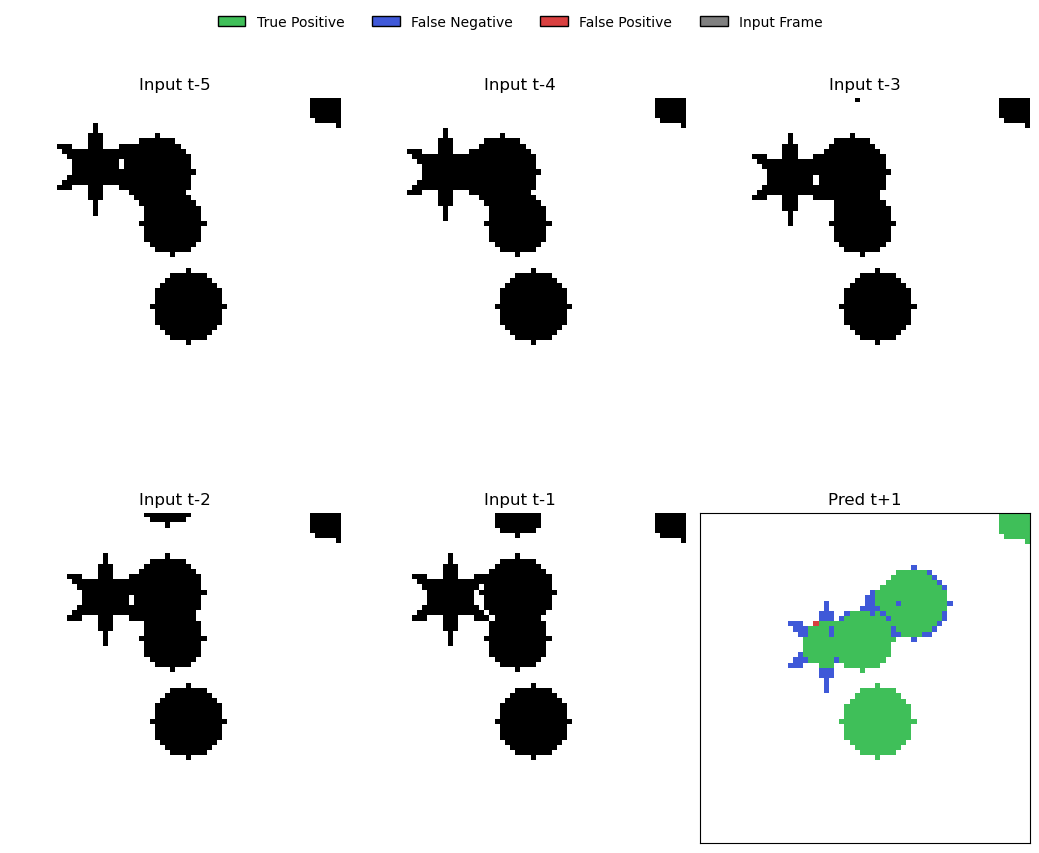

In [9]:
i = 3
prediction = pred[i].cpu()

visualize_time_series_grid_difference(prediction, y[i].cpu(), None, None, x[i][-5:].cpu(), 2, 3, 0.9, True, False)

# autoregressive

In [13]:
class Dataset_ar(Dataset):
    def __init__(self, npy_files, input_len=10, pred_steps=10):
        self.input_len = input_len
        self.pred_steps = pred_steps

        self.data = []
        for f in npy_files:
            arr = np.load(f, mmap_mode="r")  # (N,T,1,64,64)
            self.data.append(arr)

        self.data = np.concatenate(self.data, axis=0)
        self.data = self.data[:,:,None,:,:]
        self.N, self.T, self.C, self.H, self.W = self.data.shape

        self.valid_t = list(
            range(input_len - 1, self.T - pred_steps)
        )

        self.samples_per_seq = len(self.valid_t)
        self.total_samples = self.N * self.samples_per_seq

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        seq_idx = idx // self.samples_per_seq
        t_idx = idx % self.samples_per_seq
        t = self.valid_t[t_idx]

        seq = self.data[seq_idx]

        x = seq[t - self.input_len + 1 : t + 1]             # (10,1,64,64)
        y = seq[t + 1 : t + 1 + self.pred_steps]            # (10,1,64,64)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        x = x.reshape(-1, self.H, self.W)                   # (10,64,64)

        return x, y


In [14]:
dataset = Dataset_ar(files, input_len=10, pred_steps=10)

n_total = len(dataset)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

In [15]:
def autoregressive_loss(model, x, y, criterion, tf_ratio=0.7):
    """
    x: (B,10,64,64)
    y: (B,10,1,64,64)
    """
    K = y.size(1)
    cur = x
    total_loss = 0.0

    for k in range(K):
        delta = model(cur)
        pred = cur[:, -1:] + delta

        total_loss += criterion(pred, y[:, k])

        if torch.rand(1).item() < tf_ratio:
            next_in = y[:, k]
        else:
            next_in = pred

        cur = torch.cat([cur[:, 1:], next_in], dim=1)

    return total_loss / K

In [ ]:


EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-4
DEVICE = "cuda" 
SAVE_PATH = "unet_model_ar.pt"
print(DEVICE)


model = unet.UNet(in_channels=10, out_channels=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


if os.path.exists("checkpoint.pt"):
    ckpt = torch.load("checkpoint.pt", map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    start_epoch = ckpt["epoch"] + 1
    print("Resumed from epoch", start_epoch)

else:
    start_epoch = 0
criterion = nn.L1Loss()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

best_val = float("inf")

for epoch in range(start_epoch, EPOCHS):

    if os.path.exists("loss.npy"):
        loss_history = list(np.load("loss.npy"))
    else:
        loss_history = []

    model.train()
    train_loss = 0.0

    tf_ratio = max(0.1, 1.0 - epoch / 30)

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        loss = autoregressive_loss(model, x, y, criterion, tf_ratio)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            loss = autoregressive_loss(model, x, y, criterion, tf_ratio=0.0)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train {train_loss:.5f} | Val {val_loss:.5f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print("✔ Saved best model")

    torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, 'checkpoint.pt')
    loss_history.append((epoch ,train_loss, val_loss))
    np.save("loss.npy", np.array(loss_history))

    torch.save(model.state_dict(), f'checkpoints/checkpoint_epoch_{epoch}')


cuda
Resumed from epoch 28


Epoch 29/50:   0%|          | 1/591 [00:19<3:08:56, 19.22s/it]


KeyboardInterrupt: 

In [ ]:


def visualize_one_sample(model, dataset, idx=0, steps=10):
    model.eval()

    x, y = dataset[idx]

    # add batch dim
    x = x.unsqueeze(0).to(DEVICE)   # (1,10,64,64)
    y = y.to(DEVICE)             # (10,1,64,64)

    preds = []
    x_roll = x.clone()

    with torch.no_grad():
        for k in range(steps):
            delta = model(x_roll)
            pred = x_roll[:, -1:] + delta

            preds.append(pred.cpu())
            x_roll = torch.cat([x_roll[:, 1:], pred], dim=1)

    preds = torch.cat(preds, dim=0)  # (steps,1,64,64)

    # ---------------- plot ----------------
    fig, axes = plt.subplots(3, steps, figsize=(2*steps, 6))

    for k in range(steps):
        axes[0, k].imshow(x[0, -1].cpu(), cmap="gray")
        axes[0, k].set_title("Last input")
        axes[0, k].axis("off")

        axes[1, k].imshow(preds[k, 0], cmap="gray")
        axes[1, k].set_title(f"Pred t+{k+1}")
        axes[1, k].axis("off")

        axes[2, k].imshow(y[k, 0].cpu(), cmap="gray")
        axes[2, k].set_title(f"GT t+{k+1}")
        axes[2, k].axis("off")

    plt.tight_layout()
    plt.show()


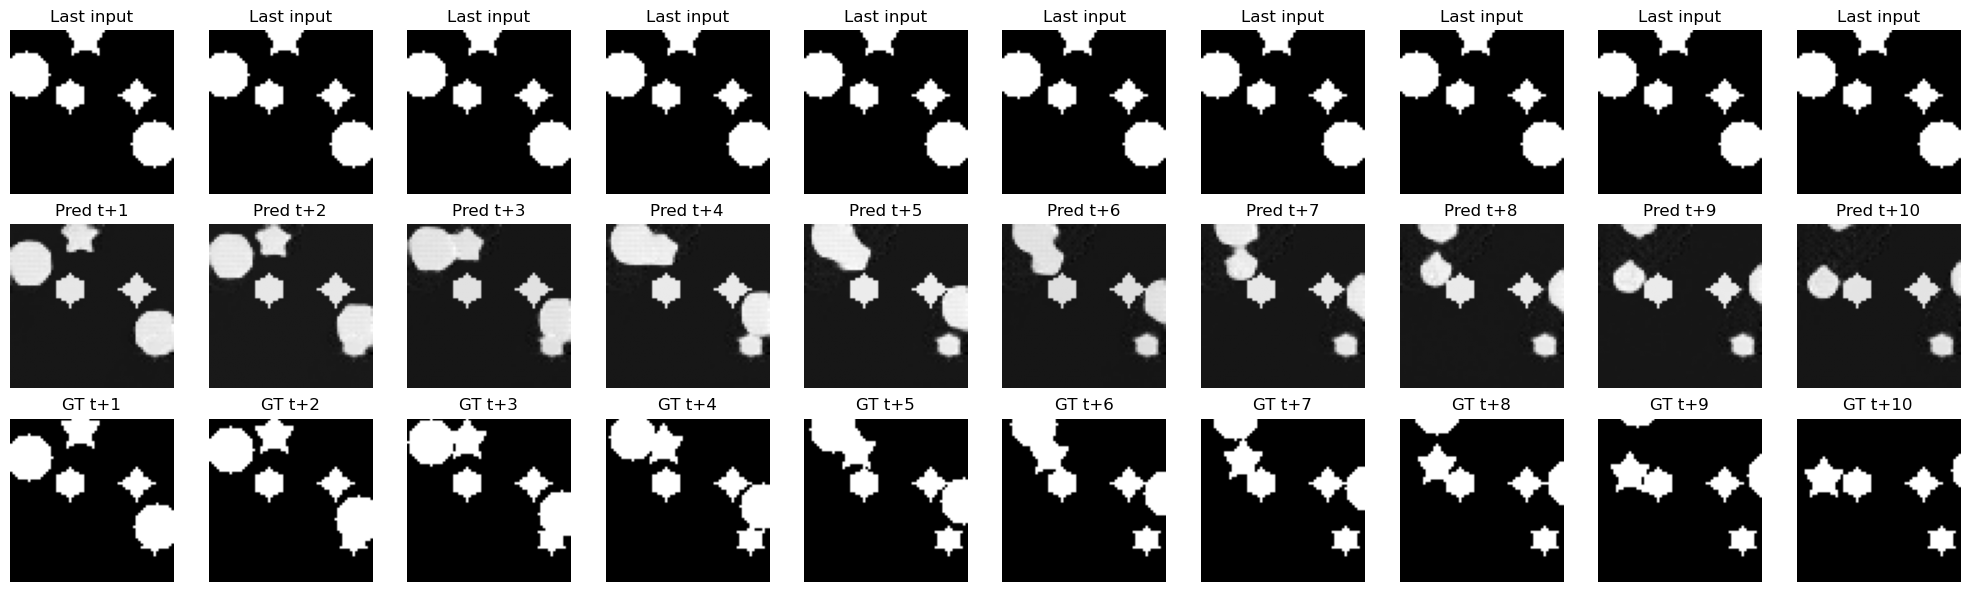

In [15]:
visualize_one_sample(model, val_dataset, 2, 10)

In [16]:

# model = unet.UNet(in_channels=10)
# model.load_state_dict(torch.load('unet_model_ar.pt'))
x, y = val_dataset[2]

# add batch dim
x = x.unsqueeze(0).to(DEVICE)   # (1,10,64,64)
                # (10,1,64,64)
y = y.squeeze(1)[:9].to(DEVICE)
preds = []
x_roll = x.clone()

with torch.no_grad():
    for k in range(9):
        delta = model(x_roll)
        pred = x_roll[:, -1:] + delta

        preds.append(pred.cpu())
        x_roll = torch.cat([x_roll[:, 1:], pred], dim=1)

preds = torch.cat(preds, dim=0).cpu().squeeze(1)

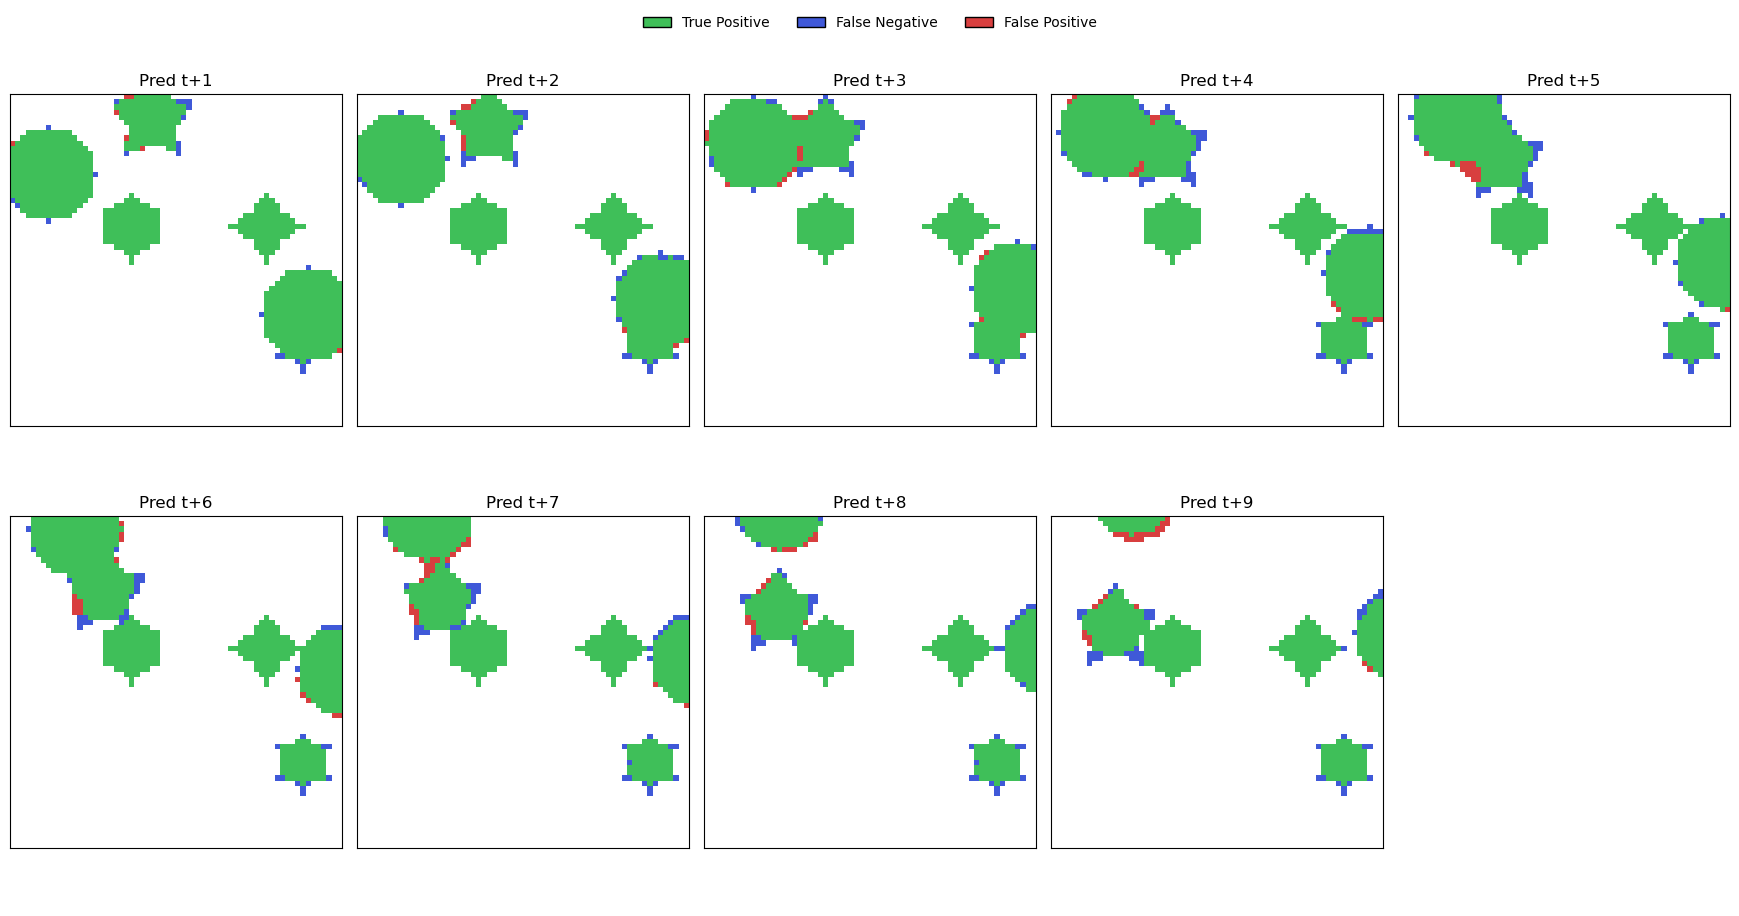

In [17]:
visualize_time_series_grid_difference(preds, y.cpu(), output_path="", show_window=True, save_image=False, threshold=0.5)

In [80]:
loss = np.load('loss.npy')
loss.shape

(28, 3)

[0.03049798 0.02159344 0.02148169 0.02169595 0.02222386 0.02270036
 0.02307107 0.01962327 0.01530326 0.01365631 0.01278071 0.01222797
 0.01135733 0.01172905 0.01112676 0.01089961 0.01131362 0.011014
 0.01088299 0.01144294 0.01130931 0.01140332 0.01219936 0.01200306
 0.01224641 0.01304892 0.01379337 0.01354006]
[0.07703393 0.07285311 0.07189226 0.07263229 0.07062081 0.0700906
 0.06745635 0.04062109 0.03270086 0.02833824 0.02590672 0.02733529
 0.02336929 0.02214228 0.01962872 0.01975287 0.0201768  0.01820015
 0.01813297 0.0192278  0.01754452 0.0214049  0.01830577 0.01750158
 0.01689648 0.01553155 0.01493403 0.01568658]


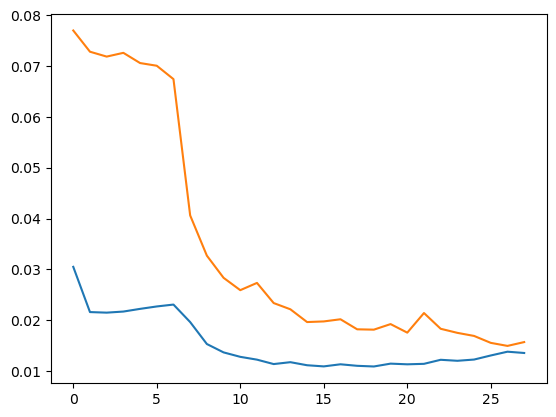

In [81]:
import matplotlib.pyplot as plt
plt.plot(loss[:, 0], loss[:, 1])
print(loss[:, 1])
plt.plot(loss[:, 0], loss[:, 2])
print(loss[:, 2])
plt.show()

# Visualisations

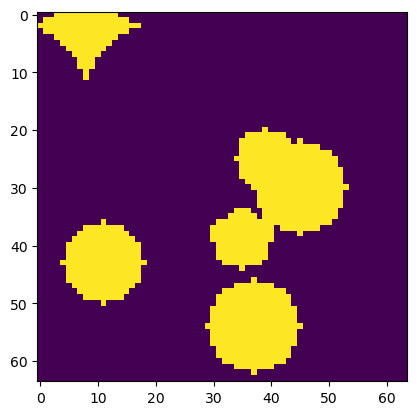

In [16]:
# load test set
test_data = np.load('dynamic_scenes2d/test_data.npy')
example = test_data[141]
plt.imshow(example[0])


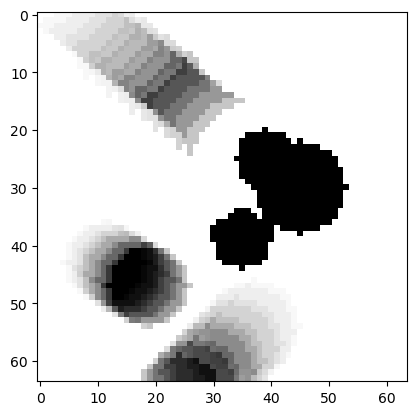

In [79]:
weights = torch.exp(torch.linspace(0, 2, 10))
weights = weights / weights.sum()
weights = weights.view(10, 1, 1)

result = (torch.Tensor(test_data[i][0:10]) * weights).sum(dim=0)


plt.imshow(result, cmap='binary')

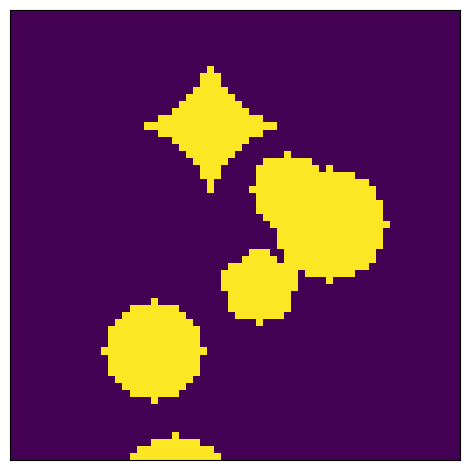

In [80]:
plt.imshow(np.sum(test_data[i][0:10], axis=0), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.savefig("plots/high_res_plot.png", dpi=300,bbox_inches="tight",
    pad_inches=0, )
plt.imshow(test_data[i][10])

In [67]:
def bce_metric(pred, target, threshold = 0.5, bin = False):
    pred = torch.clamp(pred, max=1.0, min=0)
    if bin:
        
        pred = (pred >= threshold).float()
        target = (target >= threshold).float()
    bce = F.binary_cross_entropy(pred, target)
    return bce

def mse_metric(pred, target, threshold = 0.5, bin = False):
    pred = torch.clamp(pred, max=1.0, min=0)
    if bin:
        
        pred = (pred >= threshold).float()
        target = (target >= threshold).float()
    mse = F.mse_loss(pred, target)
    return mse

def f1_metric(pred, target, threshold = 0.5):
    pred_bin = (pred >= threshold).float()
    target_bin = (target >= threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()

    f1 = 2 * tp / (2 * tp + fp + fn + 1e-7)
    return f1

def accuracy_metric(pred, target, threshold = 0.5):
    pred_bin = (pred >= threshold).float()
    target_bin = (target >= threshold).float()

    acc = (pred_bin == target_bin).float().mean()
    return acc

In [68]:
test_model = unet.UNet(10)
test_model.load_state_dict(torch.load('checkpoints/checkpoint_epoch_26'))

i = 141


x = test_data[i][None, :10, :, :]
y = test_data[i][10:19, :, :]
x = torch.Tensor(x)

metrics = []
preds = []


with torch.no_grad():
    for k in range(9):
        
        delta = test_model(x)
        pred = x[:, -1:] + delta
        target = y[k]                   # shape: (1, H, W)
        # if mse_metric expects same shape, add channel dimension
        target = torch.Tensor(target).unsqueeze(0).unsqueeze(0)      # now shape: (1, 1, H, W)

        

        mse = mse_metric(pred, target)
        bce = bce_metric(pred, target)
        mse_bin = mse_metric(pred, target, bin=True)
        bce_bin = bce_metric(pred, target, bin=True)
        f1 = f1_metric(pred, target)
        acc = accuracy_metric(pred, target)
        metrics.append(
            {'bce': bce,
             'mse': mse,
             'mse_bin': mse_bin,
             'bce_bin': bce_bin,
             'accuracy': acc,
             'f1': f1}
        )

        preds.append(pred.cpu())
        x = torch.cat([x[:, 1:], pred], dim=1)


preds = torch.cat(preds, dim=0).cpu().squeeze(1)



visualize_time_series_grid_difference(preds, y,  show_window=False, save_image=True, threshold=0.5, loss_metrics=metrics, n_rows=3, n_cols=3, output_path = r'image.png')

In [25]:
test_dataset = Dataset_ar(files, input_len=10, pred_steps=10)
BATCH_SIZE = 1024
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [29]:
def test_autoregressive_loss(model, x, y, criterion, tf_ratio=0.7):
    """
    x: (B,10,64,64)
    y: (B,10,1,64,64)
    """
    K = y.size(1)
    cur = x
    total_loss = 0.0

    total_mse = 0.0
    total_bce = 0.0
    total_mse_bin = 0.0
    total_bce_bin = 0.0
    total_f1 = 0.0
    total_acc = 0.0

    for k in range(K):
        
        delta = model(cur)
        pred = cur[:, -1:] + delta
        

        total_loss += criterion(pred, y[:, k])
        target = y[:, k]
        
        total_mse += mse_metric(pred, y[:, k])
        total_bce += bce_metric(pred, y[:, k])
        # total_mse_bin += bce_metric(pred, y[:, k], bin = True)
        # total_bce_bin += bce_metric(pred, y[:, k], bin = True)
        total_f1 += f1_metric(pred, y[:, k])
        total_acc += accuracy_metric(pred, y[:, k])

        if torch.rand(1).item() < tf_ratio:
            next_in = y[:, k]
        else:
            next_in = pred

        cur = torch.cat([cur[:, 1:], next_in], dim=1)

    return total_loss / K, total_mse/K, total_bce/K, total_mse_bin/K, total_bce_bin/K, total_f1/K, total_acc/K

In [30]:
DEVICE_TEST = "cuda"
best_f1 = 0
best_f1_epoch = None
best_loss = float("inf")
best_loss_epoch = None

criterion = nn.L1Loss()
model = unet.UNet(in_channels=10, out_channels=1)

for epoch in range(1, 28):
    SAVE_PATH = f'checkpoints/checkpoint_epoch_{epoch}'

    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE_TEST))
    model.to(DEVICE_TEST)
    model.eval()

    test_loss = 0.0

    test_mse = 0.0
    test_bce = 0.0
    test_mse_bin = 0.0
    test_bce_bin = 0.0
    test_f1 = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(test_loader):
            x = x.to(DEVICE_TEST)
            y = y.to(DEVICE_TEST)

            loss, mse, bce, mse_bin, bce_bin, f1, acc = test_autoregressive_loss(model, x, y, criterion, tf_ratio=0.0)
            test_loss += loss.item() * x.size(0)

            test_mse += mse.item() * x.size(0)
            test_bce += bce.item() * x.size(0)
            test_mse_bin += mse_bin * x.size(0)
            test_bce_bin += bce_bin * x.size(0)
            test_f1 += f1 * x.size(0)
            test_acc += acc * x.size(0)

    test_loss /= len(test_loader.dataset)

    test_mse /= len(test_loader.dataset)
    test_bce /= len(test_loader.dataset)
    test_mse_bin /= len(test_loader.dataset)
    test_bce_bin /= len(test_loader.dataset)
    test_f1 /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_f1_epoch = epoch
    if test_loss < best_loss:
        best_loss = test_loss
        best_loss_epoch = epoch

    print('---------------------')
    print('Epoch: ', epoch)
    print("Test Loss:", test_loss)

    print("Test MSE:", test_mse)
    print("Test BCE:", test_bce)
    print("Test MSE bin:", test_mse_bin)
    print("Test BCE bin:", test_bce_bin)
    print("Test F1:", test_f1)
    print("Test Accuracy:", test_acc)

print('Best Loss: ', best_loss, ' from Epoch: ', best_loss_epoch)
print('Best F1: ', best_f1, ' from Epoch: ', best_f1_epoch)


100%|██████████| 83/83 [03:55<00:00,  2.84s/it]


---------------------
Epoch:  1
Test Loss: 0.0730973344331696
Test MSE: 0.2427587134611039
Test BCE: 0.6779370951425462
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7444, device='cuda:0')
Test Accuracy: tensor(0.9313, device='cuda:0')


100%|██████████| 83/83 [03:58<00:00,  2.87s/it]


---------------------
Epoch:  2
Test Loss: 0.07214137507904143
Test MSE: 0.2425648540485473
Test BCE: 0.6776802827063061
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7444, device='cuda:0')
Test Accuracy: tensor(0.9313, device='cuda:0')


100%|██████████| 83/83 [03:54<00:00,  2.82s/it]


---------------------
Epoch:  3
Test Loss: 0.07287774061872845
Test MSE: 0.24308833155745552
Test BCE: 0.6787336712337676
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7444, device='cuda:0')
Test Accuracy: tensor(0.9313, device='cuda:0')


100%|██████████| 83/83 [03:55<00:00,  2.84s/it]


---------------------
Epoch:  4
Test Loss: 0.07086177322552317
Test MSE: 0.24217592087813786
Test BCE: 0.6767897200811477
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7444, device='cuda:0')
Test Accuracy: tensor(0.9313, device='cuda:0')


100%|██████████| 83/83 [03:56<00:00,  2.85s/it]


---------------------
Epoch:  5
Test Loss: 0.0703295987134888
Test MSE: 0.24197980512891498
Test BCE: 0.6763326477096194
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7444, device='cuda:0')
Test Accuracy: tensor(0.9313, device='cuda:0')


100%|██████████| 83/83 [03:53<00:00,  2.82s/it]


---------------------
Epoch:  6
Test Loss: 0.06770224029109592
Test MSE: 0.24136739907378243
Test BCE: 0.6748628334544954
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7522, device='cuda:0')
Test Accuracy: tensor(0.9343, device='cuda:0')


100%|██████████| 83/83 [03:54<00:00,  2.82s/it]


---------------------
Epoch:  7
Test Loss: 0.0406487379301162
Test MSE: 0.23350394543579647
Test BCE: 0.6579490366890317
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.8786, device='cuda:0')
Test Accuracy: tensor(0.9687, device='cuda:0')


100%|██████████| 83/83 [03:55<00:00,  2.84s/it]


---------------------
Epoch:  8
Test Loss: 0.03246548949394907
Test MSE: 0.23223671671890078
Test BCE: 0.655177589075906
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9068, device='cuda:0')
Test Accuracy: tensor(0.9761, device='cuda:0')


100%|██████████| 83/83 [03:55<00:00,  2.84s/it]


---------------------
Epoch:  9
Test Loss: 0.028257245114161854
Test MSE: 0.23095211573441823
Test BCE: 0.6524140869095212
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9183, device='cuda:0')
Test Accuracy: tensor(0.9793, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.79s/it]


---------------------
Epoch:  10
Test Loss: 0.025650322629582313
Test MSE: 0.2303633230129878
Test BCE: 0.6511369791712079
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9302, device='cuda:0')
Test Accuracy: tensor(0.9820, device='cuda:0')


100%|██████████| 83/83 [03:57<00:00,  2.86s/it]


---------------------
Epoch:  11
Test Loss: 0.027007514096441722
Test MSE: 0.23140056496574765
Test BCE: 0.6532971671649388
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9262, device='cuda:0')
Test Accuracy: tensor(0.9812, device='cuda:0')


100%|██████████| 83/83 [03:56<00:00,  2.85s/it]


---------------------
Epoch:  12
Test Loss: 0.022974145987204143
Test MSE: 0.2303505961043494
Test BCE: 0.6510117591222128
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9411, device='cuda:0')
Test Accuracy: tensor(0.9848, device='cuda:0')


100%|██████████| 83/83 [03:57<00:00,  2.86s/it]


---------------------
Epoch:  13
Test Loss: 0.021738047519610042
Test MSE: 0.23025563447248368
Test BCE: 0.6508546138263884
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9443, device='cuda:0')
Test Accuracy: tensor(0.9857, device='cuda:0')


100%|██████████| 83/83 [03:54<00:00,  2.82s/it]


---------------------
Epoch:  14
Test Loss: 0.019216892533359075
Test MSE: 0.22948821424870264
Test BCE: 0.6493256604103815
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9476, device='cuda:0')
Test Accuracy: tensor(0.9866, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.78s/it]


---------------------
Epoch:  15
Test Loss: 0.019364839934876987
Test MSE: 0.2292508651756105
Test BCE: 0.6488480184418814
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9465, device='cuda:0')
Test Accuracy: tensor(0.9864, device='cuda:0')


100%|██████████| 83/83 [03:50<00:00,  2.78s/it]


---------------------
Epoch:  16
Test Loss: 0.019799083139924775
Test MSE: 0.22936895931902385
Test BCE: 0.6491087868781317
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9448, device='cuda:0')
Test Accuracy: tensor(0.9858, device='cuda:0')


100%|██████████| 83/83 [03:52<00:00,  2.80s/it]


---------------------
Epoch:  17
Test Loss: 0.01776656787097454
Test MSE: 0.2295358413684936
Test BCE: 0.6493655096462795
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9484, device='cuda:0')
Test Accuracy: tensor(0.9867, device='cuda:0')


100%|██████████| 83/83 [03:50<00:00,  2.78s/it]


---------------------
Epoch:  18
Test Loss: 0.017659280702471733
Test MSE: 0.22916938101677667
Test BCE: 0.6486432474000113
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9518, device='cuda:0')
Test Accuracy: tensor(0.9875, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.79s/it]


---------------------
Epoch:  19
Test Loss: 0.018774097423468316
Test MSE: 0.2299219543025607
Test BCE: 0.6502380612464178
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9439, device='cuda:0')
Test Accuracy: tensor(0.9854, device='cuda:0')


100%|██████████| 83/83 [03:50<00:00,  2.78s/it]


---------------------
Epoch:  20
Test Loss: 0.01705634437217599
Test MSE: 0.2295324924673353
Test BCE: 0.6493483525457836
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9503, device='cuda:0')
Test Accuracy: tensor(0.9871, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.79s/it]


---------------------
Epoch:  21
Test Loss: 0.020999674980129515
Test MSE: 0.23073183590457552
Test BCE: 0.6519337330545698
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9354, device='cuda:0')
Test Accuracy: tensor(0.9832, device='cuda:0')


100%|██████████| 83/83 [03:55<00:00,  2.84s/it]


---------------------
Epoch:  22
Test Loss: 0.01781913981196426
Test MSE: 0.22980778219018663
Test BCE: 0.6499100159009298
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9569, device='cuda:0')
Test Accuracy: tensor(0.9888, device='cuda:0')


100%|██████████| 83/83 [03:54<00:00,  2.82s/it]


---------------------
Epoch:  23
Test Loss: 0.016974876484700613
Test MSE: 0.22891852253391629
Test BCE: 0.64808516341164
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9534, device='cuda:0')
Test Accuracy: tensor(0.9879, device='cuda:0')


100%|██████████| 83/83 [03:55<00:00,  2.83s/it]


---------------------
Epoch:  24
Test Loss: 0.016729621144277708
Test MSE: 0.22905128755455925
Test BCE: 0.6484575193723042
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9540, device='cuda:0')
Test Accuracy: tensor(0.9881, device='cuda:0')


100%|██████████| 83/83 [03:54<00:00,  2.82s/it]


---------------------
Epoch:  25
Test Loss: 0.015311231465211936
Test MSE: 0.2284821261451358
Test BCE: 0.6471645271664574
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9567, device='cuda:0')
Test Accuracy: tensor(0.9889, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.79s/it]


---------------------
Epoch:  26
Test Loss: 0.014678217655846051
Test MSE: 0.2290916835694086
Test BCE: 0.6484520787511553
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9576, device='cuda:0')
Test Accuracy: tensor(0.9890, device='cuda:0')


100%|██████████| 83/83 [03:51<00:00,  2.79s/it]

---------------------
Epoch:  27
Test Loss: 0.015363825435439746
Test MSE: 0.22892360728127617
Test BCE: 0.6480497649510701
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.9561, device='cuda:0')
Test Accuracy: tensor(0.9887, device='cuda:0')
Best Loss:  0.014678217655846051  from Epoch:  26
Best F1:  tensor(0.9576, device='cuda:0')  from Epoch:  26


In [12]:
DEVICE_TEST = "cuda"
best_f1 = 0
best_f1_epoch = None
best_loss = float("inf")
best_loss_epoch = None

criterion = nn.L1Loss()
model = unet.UNet(in_channels=10, out_channels=1)

for epoch in range(1, 28):
    SAVE_PATH = f'checkpoints/checkpoint_epoch_{epoch}'

    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE_TEST))
    model.to(DEVICE_TEST)
    model.eval()

    test_loss = 0.0

    test_mse = 0.0
    test_bce = 0.0
    test_mse_bin = 0.0
    test_bce_bin = 0.0
    test_f1 = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(test_loader):
            x = x.to(DEVICE_TEST)
            y = y.to(DEVICE_TEST)

            loss, mse, bce, mse_bin, bce_bin, f1, acc = test_autoregressive_loss(model, x, y, criterion, tf_ratio=0.0)
            test_loss += loss.item() * x.size(0)

            test_mse += mse.item() * x.size(0)
            test_bce += bce.item() * x.size(0)
            test_mse_bin += mse_bin * x.size(0)
            test_bce_bin += bce_bin * x.size(0)
            test_f1 += f1 * x.size(0)
            test_acc += acc * x.size(0)

    test_loss /= len(test_loader.dataset)

    test_mse /= len(test_loader.dataset)
    test_bce /= len(test_loader.dataset)
    test_mse_bin /= len(test_loader.dataset)
    test_bce_bin /= len(test_loader.dataset)
    test_f1 /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_f1_epoch = epoch
    if test_loss < best_loss:
        best_loss = test_loss
        best_loss_epoch = epoch

    print('---------------------')
    print('Epoch: ', epoch)
    print("Test Loss:", test_loss)

    print("Test MSE:", test_mse)
    print("Test BCE:", test_bce)
    print("Test MSE bin:", test_mse_bin)
    print("Test BCE bin:", test_bce_bin)
    print("Test F1:", test_f1)
    print("Test Accuracy:", test_acc)

print('Best Loss: ', best_loss, ' from Epoch: ', best_loss_epoch)
print('Best F1: ', best_f1, ' from Epoch: ', best_f1_epoch)


100%|██████████| 83/83 [04:02<00:00,  2.92s/it]


---------------------
Epoch:  1
Test Loss: 0.07309733463185174
Test MSE: 0.24275870931716192
Test BCE: 0.677937090646653
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2623, device='cuda:0')
Test Accuracy: tensor(0.2991, device='cuda:0')


100%|██████████| 83/83 [04:02<00:00,  2.93s/it]


---------------------
Epoch:  2
Test Loss: 0.07214137555020196
Test MSE: 0.24256485688686372
Test BCE: 0.6776802908125378
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.4402, device='cuda:0')
Test Accuracy: tensor(0.7048, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  3
Test Loss: 0.0728777395713897
Test MSE: 0.24308833123388746
Test BCE: 0.6787336797260103
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2531, device='cuda:0')
Test Accuracy: tensor(0.2482, device='cuda:0')


100%|██████████| 83/83 [04:02<00:00,  2.92s/it]


---------------------
Epoch:  4
Test Loss: 0.07086177310773305
Test MSE: 0.24217591930571056
Test BCE: 0.6767897230329968
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3895, device='cuda:0')
Test Accuracy: tensor(0.6359, device='cuda:0')


100%|██████████| 83/83 [04:03<00:00,  2.94s/it]


---------------------
Epoch:  5
Test Loss: 0.0703295985914412
Test MSE: 0.24197980532192048
Test BCE: 0.6763326529775348
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.5557, device='cuda:0')
Test Accuracy: tensor(0.8204, device='cuda:0')


100%|██████████| 83/83 [04:03<00:00,  2.93s/it]


---------------------
Epoch:  6
Test Loss: 0.06770223899966195
Test MSE: 0.24136739487307413
Test BCE: 0.6748628407205854
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2773, device='cuda:0')
Test Accuracy: tensor(0.3534, device='cuda:0')


100%|██████████| 83/83 [04:02<00:00,  2.92s/it]


---------------------
Epoch:  7
Test Loss: 0.040648737578164965
Test MSE: 0.23350394634405772
Test BCE: 0.6579490333965846
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.6115, device='cuda:0')
Test Accuracy: tensor(0.8438, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  8
Test Loss: 0.03246548958335604
Test MSE: 0.23223671633288973
Test BCE: 0.6551775957516262
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2836, device='cuda:0')
Test Accuracy: tensor(0.3498, device='cuda:0')


100%|██████████| 83/83 [04:00<00:00,  2.90s/it]


---------------------
Epoch:  9
Test Loss: 0.028257245287299157
Test MSE: 0.2309521157117117
Test BCE: 0.6524140808922904
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.4885, device='cuda:0')
Test Accuracy: tensor(0.7347, device='cuda:0')


100%|██████████| 83/83 [04:00<00:00,  2.90s/it]


---------------------
Epoch:  10
Test Loss: 0.025650323336323104
Test MSE: 0.23036332215013958
Test BCE: 0.6511369732902164
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3820, device='cuda:0')
Test Accuracy: tensor(0.5849, device='cuda:0')


100%|██████████| 83/83 [04:00<00:00,  2.90s/it]


---------------------
Epoch:  11
Test Loss: 0.02700751405244782
Test MSE: 0.231400563677152
Test BCE: 0.6532971612612406
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2499, device='cuda:0')
Test Accuracy: tensor(0.2162, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  12
Test Loss: 0.02297414642572403
Test MSE: 0.23035059783572243
Test BCE: 0.6510117658660526
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2527, device='cuda:0')
Test Accuracy: tensor(0.2253, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  13
Test Loss: 0.0217380484108414
Test MSE: 0.23025563460872286
Test BCE: 0.6508546122369312
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2573, device='cuda:0')
Test Accuracy: tensor(0.2445, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  14
Test Loss: 0.01921689318546227
Test MSE: 0.22948821471986317
Test BCE: 0.6493256554603577
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2879, device='cuda:0')
Test Accuracy: tensor(0.3566, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  15
Test Loss: 0.01936484042590573
Test MSE: 0.22925086525508337
Test BCE: 0.648848007996877
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.6724, device='cuda:0')
Test Accuracy: tensor(0.8758, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  16
Test Loss: 0.019799083269068173
Test MSE: 0.22936896092551096
Test BCE: 0.6491087936900911
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3981, device='cuda:0')
Test Accuracy: tensor(0.6116, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  17
Test Loss: 0.017766568075688112
Test MSE: 0.2295358410619554
Test BCE: 0.6493655083974202
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3762, device='cuda:0')
Test Accuracy: tensor(0.5706, device='cuda:0')


100%|██████████| 83/83 [04:01<00:00,  2.91s/it]


---------------------
Epoch:  18
Test Loss: 0.017659280561265492
Test MSE: 0.22916938486553373
Test BCE: 0.6486432528041658
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.6612, device='cuda:0')
Test Accuracy: tensor(0.8684, device='cuda:0')


100%|██████████| 83/83 [04:08<00:00,  2.99s/it]


---------------------
Epoch:  19
Test Loss: 0.018774097504360335
Test MSE: 0.22992195221923648
Test BCE: 0.6502380638576689
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3296, device='cuda:0')
Test Accuracy: tensor(0.4717, device='cuda:0')


100%|██████████| 83/83 [04:10<00:00,  3.02s/it]


---------------------
Epoch:  20
Test Loss: 0.01705634382580008
Test MSE: 0.22953249632744563
Test BCE: 0.6493483553841001
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3022, device='cuda:0')
Test Accuracy: tensor(0.3957, device='cuda:0')


100%|██████████| 83/83 [04:08<00:00,  2.99s/it]


---------------------
Epoch:  21
Test Loss: 0.020999674122248378
Test MSE: 0.23073183458759672
Test BCE: 0.6519337324641999
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2598, device='cuda:0')
Test Accuracy: tensor(0.2579, device='cuda:0')


100%|██████████| 83/83 [04:15<00:00,  3.08s/it]


---------------------
Epoch:  22
Test Loss: 0.017819139760874566
Test MSE: 0.22980777892044613
Test BCE: 0.6499100109054928
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2517, device='cuda:0')
Test Accuracy: tensor(0.2164, device='cuda:0')


100%|██████████| 83/83 [04:17<00:00,  3.11s/it]


---------------------
Epoch:  23
Test Loss: 0.016974876830265634
Test MSE: 0.2289185210636684
Test BCE: 0.6480851630937485
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.7185, device='cuda:0')
Test Accuracy: tensor(0.8996, device='cuda:0')


100%|██████████| 83/83 [04:16<00:00,  3.10s/it]


---------------------
Epoch:  24
Test Loss: 0.01672962058725811
Test MSE: 0.2290512879632768
Test BCE: 0.6484575219608488
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.3305, device='cuda:0')
Test Accuracy: tensor(0.4734, device='cuda:0')


100%|██████████| 83/83 [04:13<00:00,  3.05s/it]


---------------------
Epoch:  25
Test Loss: 0.01531123157342275
Test MSE: 0.22848212420372735
Test BCE: 0.6471645205815633
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.6904, device='cuda:0')
Test Accuracy: tensor(0.8850, device='cuda:0')


100%|██████████| 83/83 [04:15<00:00,  3.08s/it]


---------------------
Epoch:  26
Test Loss: 0.014678217007645539
Test MSE: 0.22909167931193397
Test BCE: 0.6484520759355454
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.2970, device='cuda:0')
Test Accuracy: tensor(0.3798, device='cuda:0')


100%|██████████| 83/83 [04:18<00:00,  3.11s/it]

---------------------
Epoch:  27
Test Loss: 0.015363825198440324
Test MSE: 0.22892360591320765
Test BCE: 0.6480497634297325
Test MSE bin: 0.0
Test BCE bin: 0.0
Test F1: tensor(0.5729, device='cuda:0')
Test Accuracy: tensor(0.8074, device='cuda:0')
Best Loss:  0.014678217007645539  from Epoch:  26
Best F1:  tensor(0.7185, device='cuda:0')  from Epoch:  23
